# 线性回归
- 矢量化加速

In [41]:
%matplotlib inline
import math
# math 是 Python 内置的数学函数库，专门提供数学运算相关的功能。它包含了很多常用的数学常量（比如 π、e）和函数（比如平方根、三角函数、对数等）
import time
# python内置的与时间相关的模块
import numpy as np
import torch
from d2l import torch as d2l

In [42]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])
a, b

(tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [43]:
class Timer:
    def __init__(self):
        # 注意，这里是双下划线而不是单下划线
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    

In [44]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'


'0.06467 sec'

相比for循环，速度快的多得多!

In [45]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

- 解读平方损失目标函数

In [46]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

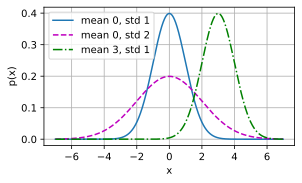

In [47]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 线性回归的从零开始实现

> 实验大致流程，人为设定权重和偏置值，通过线性拟合函数来随机生成数据集，再通过随机梯度下降法(SGD)来更新参数，看看最后和人为设定真实值的差距有多大

In [48]:
%matplotlib inline
# 常用的一个魔法指令，能够让图像直接显示在notebook中
import random
# 导入用于生成随机数的库
import torch
from torch.utils import data
from d2l import torch as d2l
# 导入封装库

生成数据集

Question：
为什么生成数据要服从正态分布？
简单理解，自然界和社会现象中大量变量近似服从正态分布。（联系考研的概率论）

In [49]:
def synthetic_data(w, b, num_examples):
    # 定义合成数据函数，三个参数，w:权重，b：偏置量， num_examples: 要生成的数据样本数量
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    """
    normal函数是用于生成服从正态分布的随机数张量
    torch.normal(mean, std, *, generator=None, out=None)，均值、标准差
    生成均值为0，标准差为1，形状为num_examplesxlen(w)的张量
    """
    y = torch.matmul(X, w) + b
    """
    matmul = matrix multiplication 矩阵乘法
    将X和w做矩阵乘法运算
    """
    y += torch.normal(0, 0.01, y.shape)
    """
    给y加一点噪声
    生成一个均值为0，标准差为0.01，形状与y相同的张量
    """
    return X, y.reshape((-1, 1))
    """
    这里reshape两个括号的原因仅仅是因为代码习惯问题，现在内部是一个元组。
    当然，建议养成这样的习惯
    """
# 人为设定的权重w和偏置b，也是后面参数更新的最终目标
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# features是1000x2的矩阵，labels是1000x1的矩阵
features, labels = synthetic_data(true_w, true_b, 1000)

In [50]:
true_w

tensor([ 2.0000, -3.4000])

In [51]:
true_w.size()

torch.Size([2])

- 思考

仔细思考一下维度，是不是有问题？X是1000 x 2，w是1 x 2，不满足向量维度计算规则了！

其实是因为张量只有一维的时候，并没有行或者列的概念，会自动适配行列式计算规则。

In [52]:
# 打印第一个样本的特征值和其对应的标签
print('features:', features[0],'\nlabel:', labels[0])
# \n反斜杠n表示换到下一行 

features: tensor([-0.1679, -0.0719]) 
label: tensor([4.0904])


根据输出结果可以看见，样本有两个特征。
当然也可以给生成的样本真实的环境，比如说特征是天气、睡眠质量，标签是一个人的情绪值的好坏。

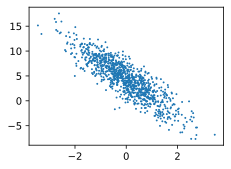

In [53]:
# 调用 set_figsize() 后，后续用 d2l.plt（其实就是 matplotlib.pyplot）画出来的图会按照预设的宽高显示，这样在 Jupyter Notebook 或脚本中看起来更清晰
d2l.set_figsize()
# 生成散点图，注意数据索引是从0开始的，所以这是调用的第二个特征
# x轴是所有行的第二个特征，y是标签数据
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

从上图可以看出特征和标签之间的线性关系

batch_size小批量数据生成。
使用小批量数据法的原因类似于随机抽样。
全批量数据训练时间长，算力消耗大。

In [54]:
  def load_array(data_arrays, batch_size, is_train=True):
      """
      data_arrays：一个元组，通常是（features, labels），直接中译理解为数据矩阵
      batch_size：每个小批量的样本数
      is_Train：bool，表示这个迭代器是否用于训练
      - True：每个epoch会随机打乱数据
      - False：数据按固定顺序读取（用于验证集/测试集）
      """
      
      """构造一个Pytorch数据迭代器"""
      dataset = data.TensorDataset(*data_arrays)
      """
      Pytorch提供的固定用法数据集封装器
      *data_arrays是解包操作，相当于(features, labels)
      """
      """
      DataLoader 是 PyTorch 的数据加载器：
      会把 dataset 按 batch_size 切成小批量
      如果 shuffle=True，会在每个 epoch 开始前随机打乱数据顺序
      返回的是一个可迭代对象，可以直接用 for 循环取数据
      """
      return data.DataLoader(dataset, batch_size, shuffle=is_train)
 

In [55]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [56]:
for X, y in data_iter:
    print('X:', X, '\ny:', y)
    break  # 这里只看第一个批次

X: tensor([[ 0.0333,  0.1850],
        [-0.9025,  0.4751],
        [ 0.8304, -0.5052],
        [ 0.4944, -1.5253],
        [-1.0034, -3.3096],
        [ 0.1475, -0.7046],
        [-0.0199,  0.2566],
        [ 0.8239, -0.9747],
        [-1.0317,  0.1758],
        [-0.5983, -1.3429]]) 
y: tensor([[ 3.6421],
        [ 0.7857],
        [ 7.5884],
        [10.3802],
        [13.4423],
        [ 6.8930],
        [ 3.2863],
        [ 9.1425],
        [ 1.5509],
        [ 7.5712]])


- 初始化模型参数
初始化设定权重w和偏置值b。

In [57]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# 从均值为 0、标准差为 0.01 的正态分布中随机采样，生成一个形状为 (2, 1) 的张量
# requires_grad=True，告诉 PyTorch：这个张量需要记录梯度信息，在反向传播时会计算它的梯度
b = torch.zeros(1, requires_grad=True)
# torch.zeros(1)，创建一个形状为 (1,) 的张量，初始值为 0。
# 偏置项通常可以安全地初始化为 0，不会影响模型的对称性破除

- 定义模型
定义线性回归模型。

In [58]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

- 定义损失函数

In [59]:
def squared_loss(y_hat, y): 
    # 这里的hat并不是帽子的含义，而是在统计学中的尖角符号，y尖，头顶有个尖角符号表示估计值或预测值
    # 当然写成y_pred也可以
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    # 把y reshape成和y预测值一样的维度
    # 除以2是数学小技巧，均方误差公式求导时会更简洁。
    # MSE是回归问题中常见使用的损失函数。

- 优化算法
这里先用书中使用的SGD，后续再尝试用momenta，Adam来进行优化器效果对比。

In [60]:
# 手写优化器，更直观感受SGD
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        # 在手写优化器或推理阶段，不追踪梯度计算是“行业惯例”
        for param in params:
            param -= lr * param.grad / batch_size
            # 这里除以 batch_size 是因为 .grad 通常是当前批次的梯度和，我们希望用平均梯度来更新（等价于损失函数取平均时的梯度）
            param.grad.zero_()
            # 把当前参数梯度清零，避免下一次计算梯度更新错误

- 模型训练

In [74]:
lr = 0.003
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X, w, b), y)
        # 前向传播计算损失函数
        l.sum().backward()
        # pytorch中反向传播的标准用法
        # sum是把当前批次的样本损失值加起来，得到一个标量。反向传播的时候只能使用标量
        sgd([w, b], lr, batch_size)
    # 这里的no_grad的用法几乎是标准用法，在验证集或推理阶段，由于参数已经被训练，因此只需要前向传播而不需要反向传播
    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')
        

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [62]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.7703, -1.3076], grad_fn=<SubBackward0>)
b的估计误差: tensor([1.6306], grad_fn=<RsubBackward1>)
